In [59]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from typing import List, Dict, Tuple, Optional
import copy
from datasets import load_dataset
from PIL import Image
import random

In [42]:
SEED = 69
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

First we just load and visualize the data from FEMNIST

In [43]:
dataset = load_dataset("flwrlabs/femnist")

DatasetDict({
    train: Dataset({
        features: ['image', 'writer_id', 'hsf_id', 'character'],
        num_rows: 814277
    })
})
We have 814277 data samples.
The keys of dictionary are-
 dict_keys(['image', 'writer_id', 'hsf_id', 'character'])


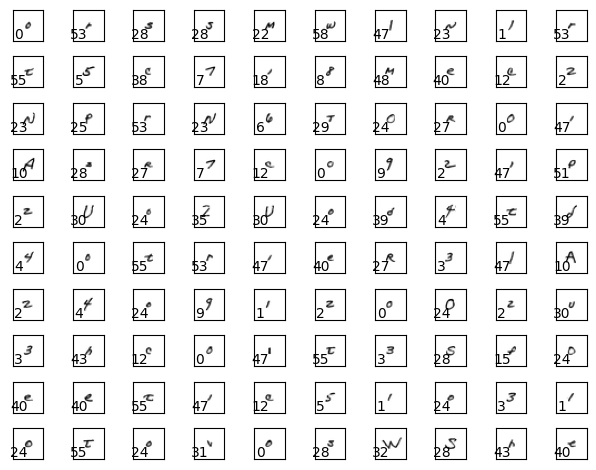

In [48]:
print(dataset)
print(60*"=")
train_ds = dataset["train"]
print(f"We have {len(train_ds)} data samples.")
example = train_ds[0]
fig,axs=plt.subplots(10,10, tight_layout = True)
for i in range(10):
    for j in range(10):
        axs[i,j].imshow(train_ds[i*10+j]["image"], cmap='grey')
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])
        axs[i,j].text(0.2, 0.2, train_ds[i*10+j]["character"], horizontalalignment='center', verticalalignment='center', transform=axs[i,j].transAxes)
print("The keys of dictionary are-\n",example.keys())           

In [51]:
split = train_ds.train_test_split(test_size=0.2, seed=42)

train_data = split["train"]
test_data = split["test"]  

print(f"Samples in train - {len(train_data)}, Samples in test - {len(test_data)}")

<class 'datasets.arrow_dataset.Dataset'>
Samples in train - 651421, Samples in test - 162856


<h3> Task1</h3>
Now the task is to give the training samples to each client<br>
We will do this by partitioning the data using a dirichlet prior<br>
Dirichlet acts like a prior over <b>class proportions per client.</b>



In [81]:
num_classes = len(train_data.features["character"].names)
num_clients = 10
print(num_classes, num_clients)

labels = np.array(train_data["character"])

62 10


In [92]:
alpha = 0.5 #larger value promotes uniform distribution smaller alpha means skewed distribution

# Grouping indices with the same class together
indices_by_class=[np.where(labels==i)[0] for i in range(num_classes)]

# client_data[c][i] = indices for class c assigned to client i
client_data = dict()
print("Number of data samples per class")
for i in range(num_classes):
    print(f"{i}->{len(indices_by_class[i])}")
# print([len(x) for x in indices_by_class])

print("Distribution of classes per client")
for c in range(num_classes):
    client_data[c]=[]
    samples_in_class = indices_by_class[c]
    num_samples_in_class = len(samples_in_class)
    if num_samples_in_class == 0:
        continue

    # Dirichlet proportions for this class across clients
    p = np.random.dirichlet(alpha * np.ones(num_clients))

    # Integer client counts
    counts = np.random.multinomial(num_samples_in_class, p)
    prev=0
    for i in range(num_clients):
        client_data[c].append(indices_by_class[c][prev:prev+counts[i]])
        prev+=counts[i]
    # OPTIONAL: Print summary
    print(f"Class {c}: {[chunk.shape[0] for chunk in client_data[c]]}")



Number of data samples per class
0->32348
1->35663
2->32257
3->32984
4->31390
5->29288
6->31999
7->33502
8->31758
9->31602
10->5924
11->3605
12->9424
13->4280
14->4632
15->8508
16->2358
17->2964
18->11161
19->3498
20->2289
21->4689
22->8457
23->7656
24->23210
25->7798
26->2388
27->4698
28->19271
29->9100
30->11630
31->4413
32->4371
33->2530
34->4416
35->2477
36->9382
37->4785
38->2621
39->9558
40->22967
41->2365
42->3445
43->8113
44->2536
45->1795
46->2350
47->14255
48->2491
49->10730
50->2595
51->2245
52->2809
53->13105
54->2494
55->16947
56->2694
57->2701
58->2567
59->2611
60->2200
61->2522
Distribution of classes per client
Class 0: [9959, 169, 2159, 24, 2944, 5563, 3460, 7276, 727, 67]
Class 1: [7336, 2934, 212, 6801, 2359, 54, 69, 6659, 132, 9107]
Class 2: [445, 2790, 6299, 5765, 441, 6, 15649, 270, 229, 363]
Class 3: [4515, 718, 9936, 2366, 4285, 65, 22, 9392, 1249, 436]
Class 4: [5804, 11233, 627, 3125, 284, 35, 1072, 1098, 7515, 597]
Class 5: [42, 5082, 1957, 133, 13579, 3756, 

In [9]:
print("\n=== Per-class label distribution across clients ===")

for c in range(num_classes):
    if c not in client_data:
        print(f"Class {c:2d}: no samples in train split")
        continue

    chunks = client_data[c]  # list of arrays, one per client
    if chunks is None or len(chunks) == 0:
        print(f"Class {c:2d}: client_data entry is empty")
        continue

    counts = np.array([len(chunk) for chunk in chunks], dtype=int)
    if counts.size == 0:
        print(f"Class {c:2d}: counts is empty (unexpected)")
        continue

    total = int(counts.sum())

    print(
        f"Class {c:2d} | total={total:5d} | "
        f"min={int(counts.min()):4d} max={int(counts.max()):4d} "
        f"mean={counts.mean():6.2f} std={counts.std():6.2f} | "
        f"per-client={counts.tolist()}"
    )



=== Per-class label distribution across clients ===
Class  0 | total=32348 | min= 246 max=7010 mean=3234.80 std=2407.37 | per-client=[1512, 7010, 1753, 6728, 3507, 1275, 459, 246, 4783, 5075]
Class  1 | total=35663 | min= 461 max=15015 mean=3566.30 std=3963.29 | per-client=[1427, 2444, 15015, 2615, 3898, 1724, 461, 4285, 1782, 2012]
Class  2 | total=32257 | min= 334 max=10080 mean=3225.70 std=3079.57 | per-client=[2794, 4934, 1463, 1971, 440, 1963, 334, 7355, 10080, 923]
Class  3 | total=32984 | min=   6 max=7542 mean=3298.40 std=2615.30 | per-client=[1338, 6, 1157, 648, 2998, 7542, 6601, 5183, 1619, 5892]
Class  4 | total=31390 | min= 144 max=10797 mean=3139.00 std=3173.52 | per-client=[3020, 10797, 3455, 1815, 774, 6680, 921, 300, 3484, 144]
Class  5 | total=29288 | min= 338 max=5216 mean=2928.80 std=1592.66 | per-client=[5216, 1645, 4431, 2391, 1182, 3245, 5015, 338, 3841, 1984]
Class  6 | total=31999 | min= 170 max=11713 mean=3199.90 std=3695.30 | per-client=[3019, 290, 170, 8359,

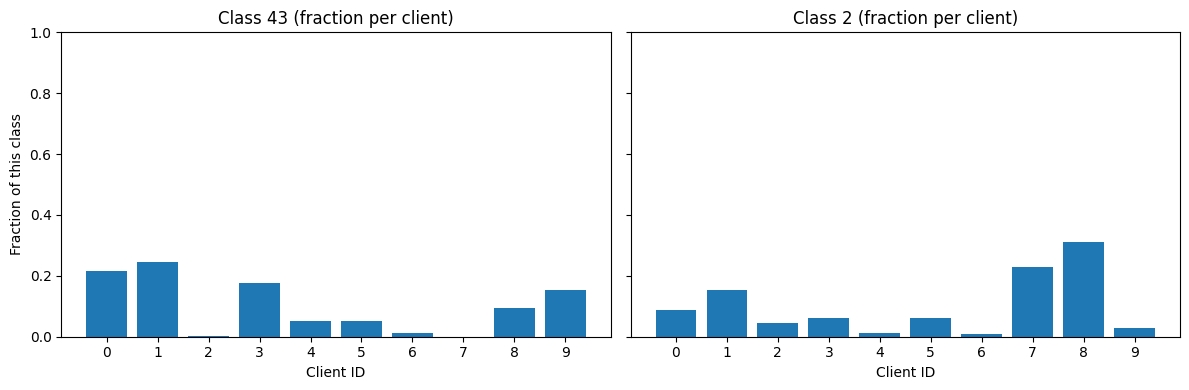

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import random

available_classes = sorted(client_data.keys())
n_plot = min(2, len(available_classes))
classes_to_plot = random.sample(available_classes, n_plot)

counts_list = []
for c in classes_to_plot:
    chunks = client_data[c]
    counts = np.array([len(chunk) for chunk in chunks], dtype=int)
    counts_list.append(counts)

fig, axes = plt.subplots(1, n_plot, figsize=(6 * n_plot, 4), sharey=True)
if n_plot == 1:
    axes = [axes]

for ax, c, counts in zip(axes, classes_to_plot, counts_list):
    frac = counts / counts.sum()          # normalize to [0,1]
    ax.bar(np.arange(len(frac)), frac)
    ax.set_title(f"Class {c} (fraction per client)")
    ax.set_xlabel("Client ID")
    ax.set_xticks(np.arange(len(frac)))
    ax.set_ylim(0, 1.0)                   # same y-axis for all

axes[0].set_ylabel("Fraction of this class")
plt.tight_layout()
plt.show()


In [ ]:
class FemnistCNN(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()
        # Input: (N, 1, 28, 28)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)  # halves H and W
        self.dropout2d = nn.Dropout2d(p=0.25)

        # After two pools: 28 -> 14 -> 7, channels = 64
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # x: (N, 1, 28, 28)
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)       # (N, 32, 14, 14)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)       # (N, 64, 7, 7)
        x = self.dropout2d(x)

        x = torch.flatten(x, 1)  # (N, 64*7*7)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)          # (N, num_classes)
        return x
num_classes = len(train_data.features["character"].names)
model = FemnistCNN(num_classes=num_classes).to(device)
print(model)
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
test_input = torch.randn(4, 1, 28, 28).to(device)
test_output = model(test_input)
print(f"\nTest input shape: {test_input.shape}")
print(f"Test output shape: {test_output.shape}")
# %% [code]
# Build per-client index lists from the per-class Dirichlet splits (client_data)

num_clients = 10  # already used above, but restate for clarity

client_indices = [[] for _ in range(num_clients)]

for c, chunks in client_data.items():
    for cid in range(num_clients):
        client_indices[cid].extend(chunks[cid].tolist())

# Shuffle indices within each client for randomness
for cid in range(num_clients):
    random.shuffle(client_indices[cid])

# Sanity check
total_assigned = sum(len(idxs) for idxs in client_indices)
print(f"Total samples assigned to clients: {total_assigned}")
print(f"Train set size: {len(train_data)}")


!pip install torch_optimizer


from torchvision import transforms
import torch_optimizer as topt
from tqdm import tqdm
transform = transforms.Compose([
    transforms.Grayscale(),   
    transforms.ToTensor(),  
])

class FemnistTorchDataset(Dataset):
    def __init__(self, hf_dataset, indices, transform=None):
        self.hf_dataset = hf_dataset
        self.indices = list(indices)
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        ex = self.hf_dataset[self.indices[idx]]
        img = ex["image"]       # PIL image
        label = int(ex["character"])
        if self.transform is not None:
            img = self.transform(img)  # -> (1, 28, 28) tensor
        return img, label



class Node:
    def __init__(self, model: nn.Module, lr: float = 0.01):
        self.model = model
        self.lr = lr
        self.model_size=sum(p.numel() for p in self.model.parameters())


class Client(Node):
    def __init__(
        self,
        client_id,
        model,
        dataset,
        batch_size,
        optimizer_name,
        optimizer_args,
        device: torch.device = device,
    ):
        super().__init__(model, lr=optimizer_args.get("lr", 0.01) if optimizer_args else 0.01)
        self.client_id = client_id
        self.dataset = dataset
        self.batch_size = batch_size
        self.device = device

        self.dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        self.optimizer_name = optimizer_name.lower()
        self.optimizer_args = optimizer_args or {}

        self.optimizer = self._make_optimizer(self.optimizer_name, self.optimizer_args)
        self.criterion = nn.CrossEntropyLoss()

        self.model.to(self.device)

    def _make_optimizer(self, name: str, kwargs: dict):
        params = self.model.parameters()
        name = name.lower()

        if name == "sgd":
            return torch.optim.SGD(params, lr=self.lr)
        elif name == "sgd_momentum":
            momentum = kwargs.get("momentum", 0.9)
            nesterov = kwargs.get("nesterov", False)
            return torch.optim.SGD(params, lr=self.lr, momentum=momentum, nesterov=nesterov)
        elif name == "adam":
            return torch.optim.Adam(params, lr=kwargs.get("lr", 0.001))
        elif name == "adamw":
            return torch.optim.AdamW(params, lr=kwargs.get("lr", 0.001))
        elif name == "rmsprop":
            return torch.optim.RMSprop(params, lr=kwargs.get("lr", 0.001))
        elif name == "radam":
            return topt.RAdam(params, lr=kwargs.get("lr", 0.001))
        else:
            raise ValueError(f"Unknown optimizer: {name}")

    def receive_from_server(self, global_state_dict: dict):
        self.model.load_state_dict(global_state_dict)
        self.model.to(self.device)

    

    def train_local(self, local_epochs: int = 1):
        self.model.train()
        total_samples = 0
        total_loss = 0.0
    
        # Outer loop = epochs
        for epoch in range(local_epochs):
            pbar = tqdm(self.dataloader, desc=f"Client {self.client_id} | Epoch {epoch+1}/{local_epochs}", leave=False)
            
            # Inner loop = batches
            for xb, yb in pbar:
                xb = xb.to(self.device)
                yb = yb.to(self.device)
    
                logits = self.model(xb)
                loss = self.criterion(logits, yb)
    
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
    
                batch_size = xb.size(0)
                total_samples += batch_size
                total_loss += loss.item() * batch_size
    
                
                pbar.set_postfix({
                    "loss": f"{loss.item():.4f}",
                })
    
        avg_loss = total_loss / total_samples
        return total_samples, avg_loss


    def send_to_server(self):
    
        state = {k: v.detach().cpu().clone() for k, v in self.model.state_dict().items()}
        n = len(self.dataset)
        return state, n

    def evaluate(self):
        self.model.eval()
        loader = DataLoader(self.dataset, batch_size=self.batch_size, shuffle=False)
        total = 0
        correct = 0
        loss_sum = 0.0
        with torch.no_grad():
            for xb, yb in loader:
                xb = xb.to(self.device)
                yb = yb.to(self.device)

                logits = self.model(xb)
                loss = self.criterion(logits, yb)

                loss_sum += loss.item() * xb.size(0)
                preds = logits.argmax(dim=1)
                correct += (preds == yb).sum().item()
                total += xb.size(0)

        return loss_sum / total, correct / total


class Server(Node):
    def __init__(self, model, test_dataset, device):
        super().__init__(model, lr=0.01)
        self.device = device
        self.test_dataset = test_dataset
        self.model.to(self.device)
        self.criterion = nn.CrossEntropyLoss()

    def update_model(self, client_states):
        if len(client_states) == 0:
            return

        total_samples = sum(n for _, n in client_states)
        new_state = {}
        first_state = client_states[0][0]
        for k, v in first_state.items():
            new_state[k] = torch.zeros_like(v)

        for state, n in client_states:
            weight = n / total_samples
            for k, v in state.items():
                new_state[k] += weight * v

        new_state = {k: v.to(self.device) for k, v in new_state.items()}
        self.model.load_state_dict(new_state)

    def test(self):
        
        self.model.eval()
        loader = DataLoader(self.test_dataset, batch_size=128, shuffle=False)
        total = 0
        correct = 0
        loss_sum = 0.0
        with torch.no_grad():
            for xb, yb in loader:
                xb = xb.to(self.device)
                yb = yb.to(self.device)

                logits = self.model(xb)
                loss = self.criterion(logits, yb)

                loss_sum += loss.item() * xb.size(0)
                preds = logits.argmax(dim=1)
                correct += (preds == yb).sum().item()
                total += xb.size(0)

        return loss_sum / total, correct / total

    def save_checkpoint(self, path):
        torch.save(self.model.state_dict(), path)



batch_size = 32
num_clients = 10 

client_datasets = []
for cid in range(num_clients):
    ds = FemnistTorchDataset(train_data, client_indices[cid], transform=transform)
    client_datasets.append(ds)

test_dataset = FemnistTorchDataset(test_data, list(range(len(test_data))), transform=transform)


clients = []
for cid in range(num_clients):
    m = FemnistCNN(num_classes=num_classes).to(device)
    client = Client(
        client_id=cid,
        model=m,
        dataset=client_datasets[cid],
        batch_size=batch_size,
        optimizer_name="sgd",       # change to 'sgd_momentum', 'adam', 'adamw', 'rmsprop', 'radam'
        optimizer_args={},        # change lr, momentum etc 
        device=device,
    )
    clients.append(client)

server_model = FemnistCNN(num_classes=num_classes).to(device)
server = Server(server_model, test_dataset, device=device)

print(f"Created {len(clients)} clients and 1 server.")

# %% [code]
import csv
import os
import random

T = 20          # global rounds
K = 10          # local epochs per selected client
m = 5           # number of clients selected per round
results_csv = "fedavg_results_with_trainloss.csv"
ckpt_dir = "checkpoints"
os.makedirs(ckpt_dir, exist_ok=True)


with open(results_csv, "w", newline="") as f:
    writer = csv.writer(f)
    header = ["round", "train_loss", "global_loss", "global_acc"]
    writer.writerow(header)

for rnd in range(1, T + 1):
    print(f"\n=== Round {rnd} ===")
    
    # 1) sample clients
    selected_ids = random.sample(range(num_clients), m)
    print("Selected clients:", selected_ids)

    # 2) broadcast global model
    global_state = {k: v.cpu().clone() for k, v in server.model.state_dict().items()}
    for cid in selected_ids:
        clients[cid].receive_from_server(global_state)

    # 3) local training and upload
    client_states = []
    round_losses = []   # (loss, n_samples) for this round
    for cid in selected_ids:
        n_local, client_loss = clients[cid].train_local(local_epochs=K)
        state, n_samples = clients[cid].send_to_server()
        client_states.append((state, n_samples))
        round_losses.append((client_loss, n_local))
        print(f"Client {cid}: trained on {n_samples} samples, loss={client_loss:.4f}")

    # 4) aggregated training loss
    total_trained = sum(n for (_, n) in round_losses)
    train_loss_round = sum(loss * n for (loss, n) in round_losses) / total_trained
    print(f"Round {rnd} aggregated training loss = {train_loss_round:.4f}")

    # 5) server aggregation
    server.update_model(client_states)

    # 6) global test
    g_loss, g_acc = server.test()
    print(f"Server test -> loss: {g_loss:.4f}, acc: {g_acc:.4f}")

    # 7) save checkpoint
    ckpt_path = os.path.join(ckpt_dir, f"server_round_{rnd}.pt")
    server.save_checkpoint(ckpt_path)
    # 8) log to CSV
    row = [rnd, train_loss_round, g_loss, g_acc]
    with open(results_csv, "a", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(row)

print("Training finished. Results saved to:", results_csv)

# %% [code]
import pandas as pd
import matplotlib.pyplot as plt

results_csv = "fedavg_results_with_trainloss.csv"
df = pd.read_csv(results_csv)

rounds = df["round"]

# --- Training Loss vs Rounds ---
plt.figure(figsize=(6,4))
plt.plot(rounds, df["train_loss"], linewidth=2)
plt.title("Training Loss vs Rounds")
plt.xlabel("Round")
plt.ylabel("Training Loss")
plt.grid(True)
plt.show()

# --- Test Loss vs Rounds ---
plt.figure(figsize=(6,4))
plt.plot(rounds, df["global_loss"], linewidth=2)
plt.title("Test Loss vs Rounds")
plt.xlabel("Round")
plt.ylabel("Test Loss")
plt.grid(True)
plt.show()

# --- Test Accuracy vs Rounds ---
plt.figure(figsize=(6,4))
plt.plot(rounds, df["global_acc"], linewidth=2)
plt.title("Test Accuracy vs Rounds")
plt.xlabel("Round")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()


FemnistCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2d): Dropout2d(p=0.25, inplace=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=62, bias=True)
)

Total parameters: 428,350
Trainable parameters: 428,350

Test input shape: torch.Size([4, 1, 28, 28])
Test output shape: torch.Size([4, 62])
Total samples assigned to clients: 651421
Train set size: 651421
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 85.2 MB/s eta 0:00:0

Client 6: trained on 46288 samples, loss=1.5680


Client 3: trained on 76167 samples, loss=1.3771


Client 0: trained on 65873 samples, loss=1.3326


Client 5: trained on 75084 samples, loss=1.1975


Client 8: trained on 68706 samples, loss=1.3980
Round 1 aggregated training loss = 1.3586
Server test -> loss: 1.1964, acc: 0.7208

=== Round 2 ===
Selected clients: [3, 6, 8, 0, 2]


Client 3: trained on 76167 samples, loss=0.6539


Client 6: trained on 46288 samples, loss=0.6354


Client 8: trained on 68706 samples, loss=0.6750


Client 0 | Epoch 1/10:  57%|█████▋    | 1169/2059 [00:18<00:14, 63.22it/s, loss=1.0872]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=10000.0 (msgs/sec)
ServerApp.rate_limit_window=1.0 (secs)

Client 0 | Epoch 9/10:  74%|███████▍  | 1526/2059 [00:23<00:08, 63.29it/s, loss=0.6205]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=10000.0 (msgs/sec)
ServerApp.rate_limit_window=1.0 (secs)

Client 2 | Epoch 8/10:  38%|███▊      | 840/2233 [00:13<00:21, 65.38it/s, loss=0.3558] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in

Client 6: trained on 46288 samples, loss=0.5072


Client 2 | Epoch 4/10:  11%|█▏        | 252/2233 [00:04<00:31, 62.86it/s, loss=0.4547] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=10000.0 (msgs/sec)
ServerApp.rate_limit_window=1.0 (secs)



Client 2: trained on 71451 samples, loss=0.5715


Client 4 | Epoch 2/10:  15%|█▍        | 279/1866 [00:04<00:24, 63.91it/s, loss=0.5498] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=10000.0 (msgs/sec)
ServerApp.rate_limit_window=1.0 (secs)



Client 4: trained on 59704 samples, loss=0.6343


Client 3 | Epoch 1/10:   0%|          | 7/2381 [00:00<00:37, 63.04it/s, loss=0.3420]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=10000.0 (msgs/sec)
ServerApp.rate_limit_window=1.0 (secs)

Client 3 | Epoch 8/10:  13%|█▎        | 308/2381 [00:04<00:32, 64.42it/s, loss=0.5522] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=10000.0 (msgs/sec)
ServerApp.rate_limit_window=1.0 (secs)



Client 8: trained on 68706 samples, loss=0.5632
Round 3 aggregated training loss = 0.5679
Server test -> loss: 0.5081, acc: 0.8275

=== Round 4 ===
Selected clients: [2, 1, 0, 6, 9]


Client 2 | Epoch 2/10:  28%|██▊       | 623/2233 [00:09<00:24, 64.44it/s, loss=1.1539] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=10000.0 (msgs/sec)
ServerApp.rate_limit_window=1.0 (secs)

Client 2 | Epoch 9/10:  57%|█████▋    | 1281/2233 [00:19<00:14, 65.53it/s, loss=0.5509]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=10000.0 (msgs/sec)
ServerApp.rate_limit_window=1.0 (secs)

Client 0 | Epoch 7/10:  87%|████████▋ | 1788/2059 [00:29<00:04, 60.85it/s, loss=0.3833]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in

Client 1: trained on 72888 samples, loss=0.4911


Client 5 | Epoch 3/10:   2%|▏         | 56/2347 [00:00<00:36, 62.92it/s, loss=0.4549]  IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=10000.0 (msgs/sec)
ServerApp.rate_limit_window=1.0 (secs)

Client 7 | Epoch 9/10:  73%|███████▎  | 1379/1879 [00:21<00:07, 65.71it/s, loss=0.4185]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=10000.0 (msgs/sec)
ServerApp.rate_limit_window=1.0 (secs)

Client 2 | Epoch 7/10:  33%|███▎      | 728/2233 [00:11<00:23, 64.38it/s, loss=0.5392] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in

Client 6: trained on 46288 samples, loss=0.4099


Client 3 | Epoch 3/10:  84%|████████▍ | 2009/2381 [00:32<00:05, 62.43it/s, loss=0.5466]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=10000.0 (msgs/sec)
ServerApp.rate_limit_window=1.0 (secs)



Client 0: trained on 65873 samples, loss=0.3793


Client 5 | Epoch 7/10:  38%|███▊      | 895/2347 [00:14<00:22, 63.86it/s, loss=0.3645] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=10000.0 (msgs/sec)
ServerApp.rate_limit_window=1.0 (secs)

Client 9 | Epoch 9/10:  81%|████████  | 1392/1724 [00:22<00:05, 61.14it/s, loss=0.2857]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=10000.0 (msgs/sec)
ServerApp.rate_limit_window=1.0 (secs)



Client 7: trained on 60109 samples, loss=0.3394


Client 6 | Epoch 4/10:  39%|███▉      | 567/1447 [00:09<00:13, 63.66it/s, loss=0.2570] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=10000.0 (msgs/sec)
ServerApp.rate_limit_window=1.0 (secs)



Client 6: trained on 46288 samples, loss=0.3716
Round 9 aggregated training loss = 0.3958
Server test -> loss: 0.4282, acc: 0.8453

=== Round 10 ===
Selected clients: [5, 1, 0, 9, 4]


Client 5 | Epoch 1/10:  21%|██        | 496/2347 [00:07<00:29, 61.92it/s, loss=0.3121]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=10000.0 (msgs/sec)
ServerApp.rate_limit_window=1.0 (secs)

Client 4 | Epoch 6/10:   6%|▌         | 112/1866 [00:01<00:27, 64.83it/s, loss=0.6702] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=10000.0 (msgs/sec)
ServerApp.rate_limit_window=1.0 (secs)



Client 4: trained on 59704 samples, loss=0.4952
Round 10 aggregated training loss = 0.4156
Server test -> loss: 0.4080, acc: 0.8584

=== Round 11 ===
Selected clients: [5, 9, 6, 7, 1]


Client 5 | Epoch 1/10:  47%|████▋     | 1112/2347 [00:17<00:19, 63.79it/s, loss=0.6853]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=10000.0 (msgs/sec)
ServerApp.rate_limit_window=1.0 (secs)



Client 7: trained on 60109 samples, loss=0.3252


Client 1 | Epoch 4/10:  25%|██▍       | 560/2278 [00:08<00:26, 65.47it/s, loss=0.5217] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=10000.0 (msgs/sec)
ServerApp.rate_limit_window=1.0 (secs)

Client 1 | Epoch 8/10:  52%|█████▏    | 1175/2278 [00:18<00:17, 62.53it/s, loss=0.4432]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=10000.0 (msgs/sec)
ServerApp.rate_limit_window=1.0 (secs)



Client 1: trained on 72888 samples, loss=0.4199
Round 11 aggregated training loss = 0.3819
Server test -> loss: 0.4123, acc: 0.8547

=== Round 12 ===
Selected clients: [4, 7, 8, 6, 5]


Client 4 | Epoch 9/10:  27%|██▋       | 504/1866 [00:07<00:22, 61.90it/s, loss=0.3543] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=10000.0 (msgs/sec)
ServerApp.rate_limit_window=1.0 (secs)



Client 5: trained on 75084 samples, loss=0.3302
Round 13 aggregated training loss = 0.3714
Server test -> loss: 0.4078, acc: 0.8539

=== Round 14 ===
Selected clients: [7, 3, 2, 4, 5]


Client 7 | Epoch 5/10:   2%|▏         | 35/1879 [00:00<00:28, 65.05it/s, loss=0.3473]  IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=10000.0 (msgs/sec)
ServerApp.rate_limit_window=1.0 (secs)



Client 6: trained on 46288 samples, loss=0.3408


Client 3 | Epoch 2/10:  81%|████████  | 1918/2381 [00:30<00:07, 63.47it/s, loss=0.1905]